Выбор локации для скважины
=

**Цель проекта:** построить модель для определения региона с наибольшей прибылью.

**Условия задачи:**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью


**Ход исследования:**
1. Подготовка данных - загрузка и изучение общей информации из предоставленных датасетов.
2. Предобработка данных - поиск пропущенных значений, дубликатов, замена названий столбцов (приведение к нижнему регистру), поиск аномальных значений.
3. Исследовательский анализ данных - изучение распределений количественных и категориальных признаков в датасетах, определение корреляции между признаками.
4. Обучение модели линейной регрессии для выбора наилучшей метрикой для предсказания прибыли.

**Общий вывод:** Выбор наиболее прибыльного региона для разработки скважин и менее рискованного.

In [1]:
#Импорт необходимых библиотек
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
import pandas as pd
import numpy as np 
import phik
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats as st 
import sklearn

In [2]:
# инструменты
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from numpy.random import RandomState
state = RandomState(12345) 

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Обзор данных

In [3]:
#загрузка датасетов
data_0 = pd.read_csv('./geo_data_0.csv')
data_1 = pd.read_csv('./geo_data_1.csv')
data_2 = pd.read_csv('./geo_data_2.csv')

In [4]:
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


- пропусков нет ни в одной таблице;
- типы данных во всех столбцах соответствуют действительности;
- названия столбцов написаны согласно "змеиным" правилам;
- необходимо проверить данные на явные дубликаты.

## Предобработка данных

In [7]:
#поиск дубликатов
datasets = [data_0, data_1, data_2]
for name in datasets:
    print(name.duplicated().sum())

0
0
0


Явных дубликатов необнаружено.

In [8]:
for name in datasets:
    print(len(name['id'].unique()))

99990
99996
99996


Судя по всему в датасетах содержатся разные данные для одних и тех же скважин, поскольку количество уникальных id меньше, чем количество строк в датасетах. Но поскольку невозможно узнать какие из этих строк истинные, то удалять их не будем.

## Исследовательский анализ данных

In [9]:
#создание функции для построения гистограммы диаграммы размаха для количественных признаков

def hist_box(data, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column], color='Indigo')

In [10]:
num_col = ['f0', 'f1', 'f2', 'product'] #список количественных признаков

### data_0

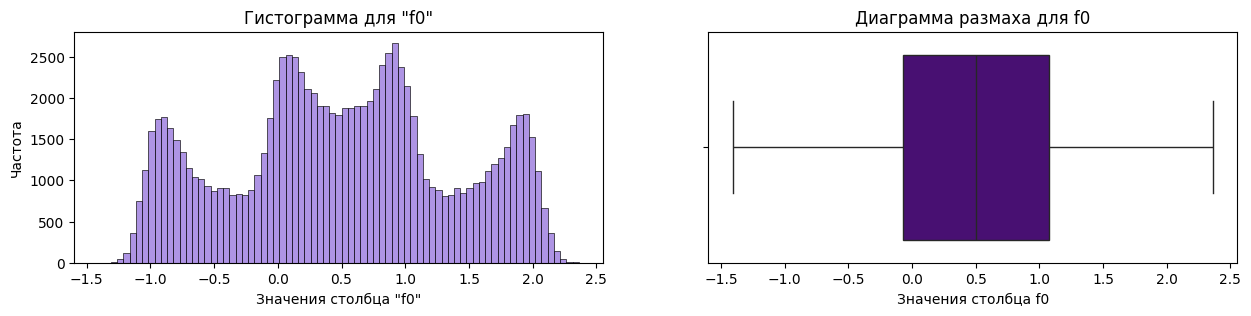

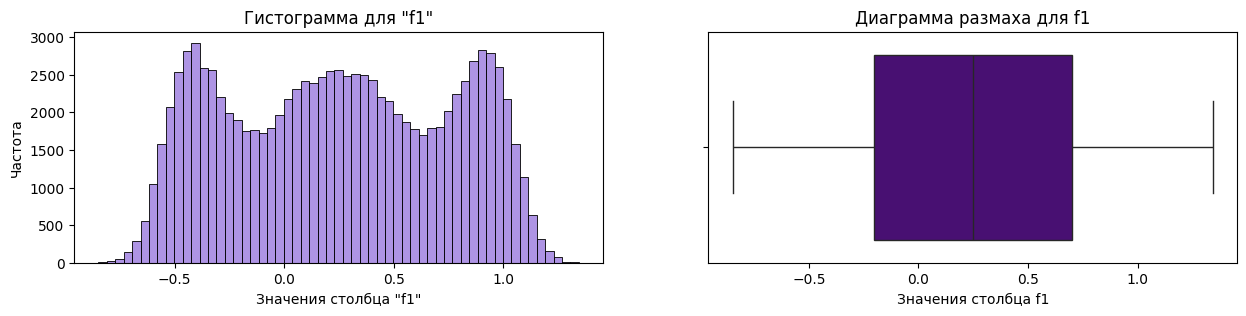

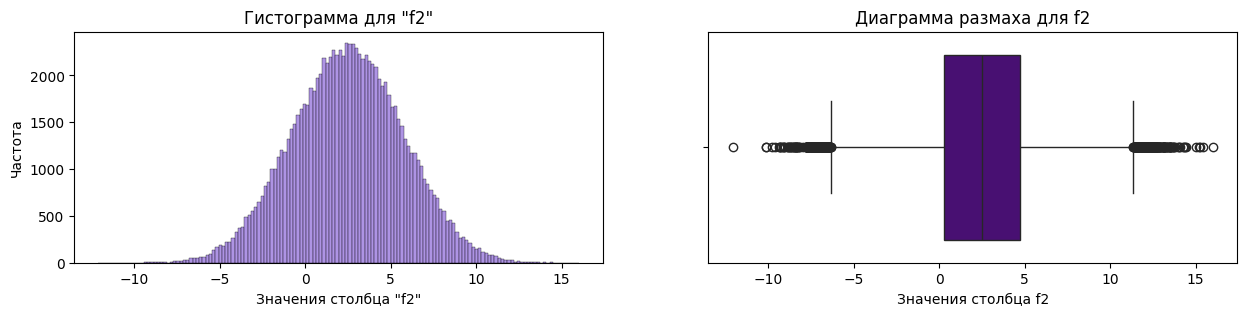

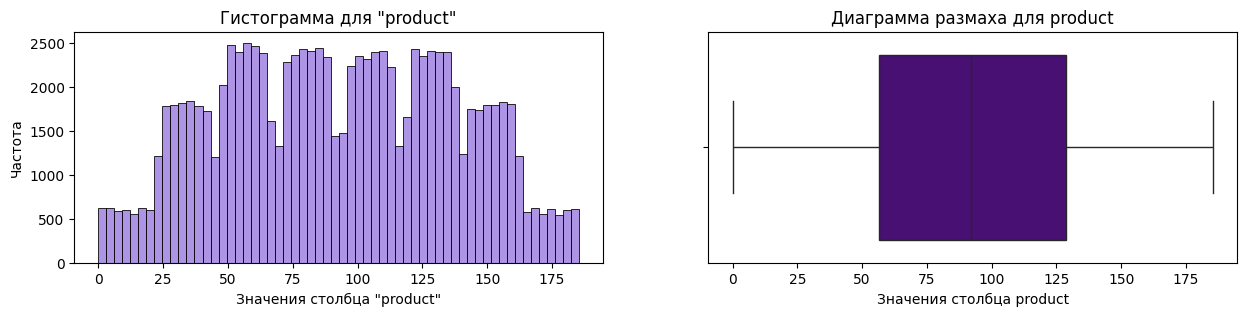

In [11]:
for name in num_col:
    hist_box(data_0, name)

- можно отметить симметричное распределение данных относительно среднего (медианного) значения;
- признак `f2` распределен нормально;
- аномальных значений в данных не наблюдается.


Рассмотрим наличие линейной взаимосвязи между целевой переменной и входными признаками.

In [12]:
num_col_1 = ['f0', 'f1', 'f2']

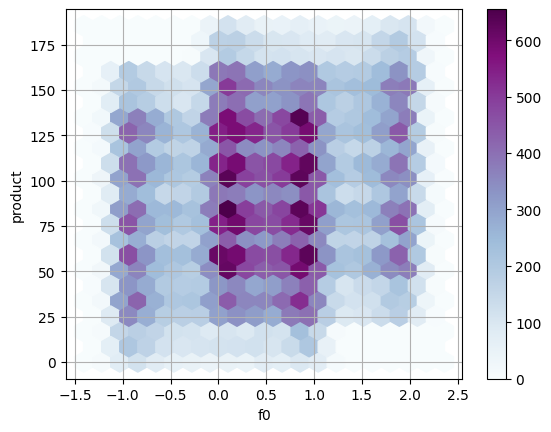

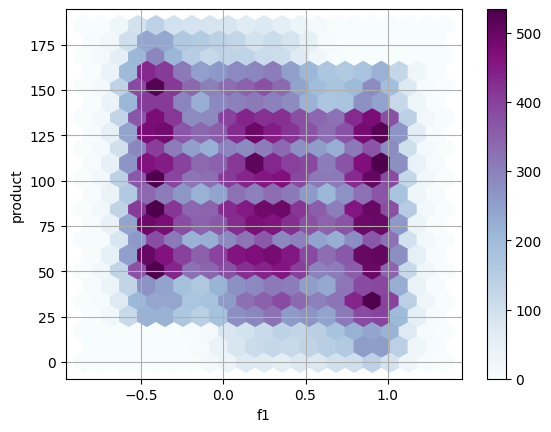

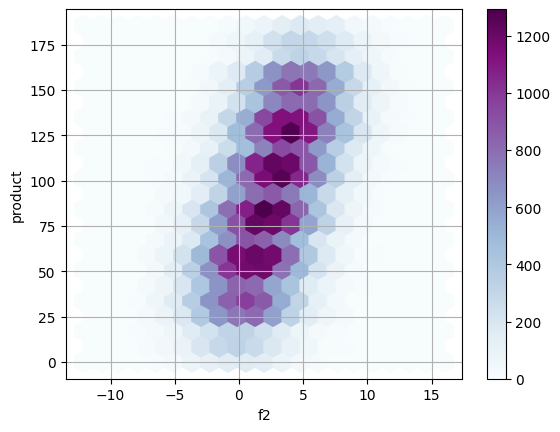

In [13]:
for name in num_col_1:
    data_0.plot(x=name, 
                y='product', 
                kind='hexbin', 
                gridsize=20, 
                sharex=False, 
                grid=True, 
                colormap='BuPu')

Сложно говорить о линейной взаимосвязи признаков `f0` и `f1` с целевым признаком. Для признака `f2` виднеется линейная взаимосвязь с целевым признаком.

### data_1

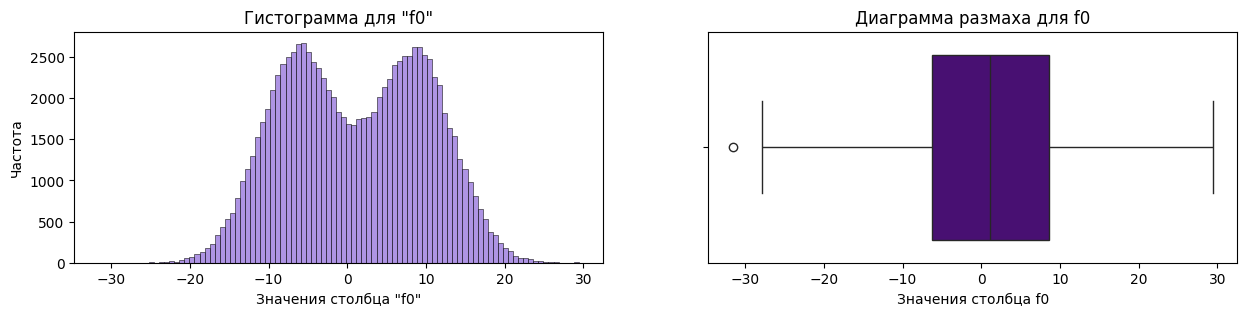

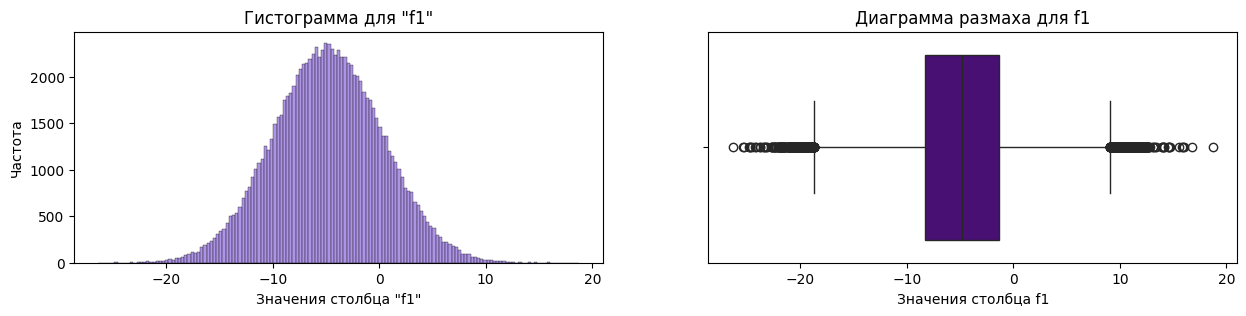

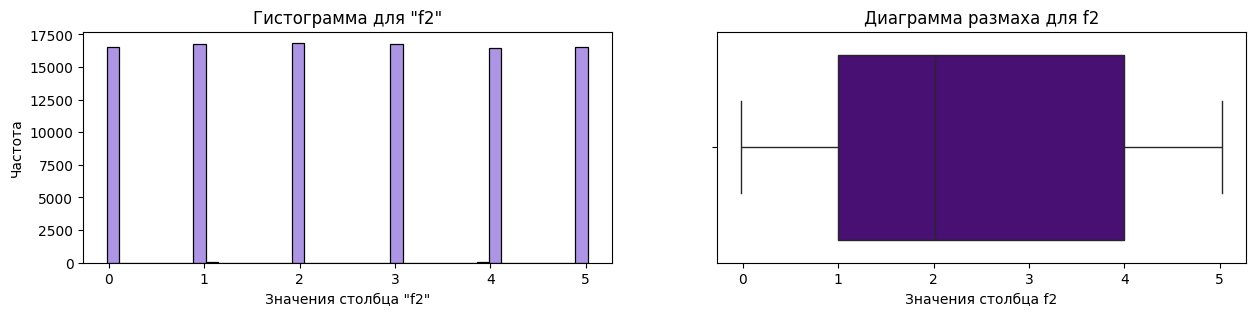

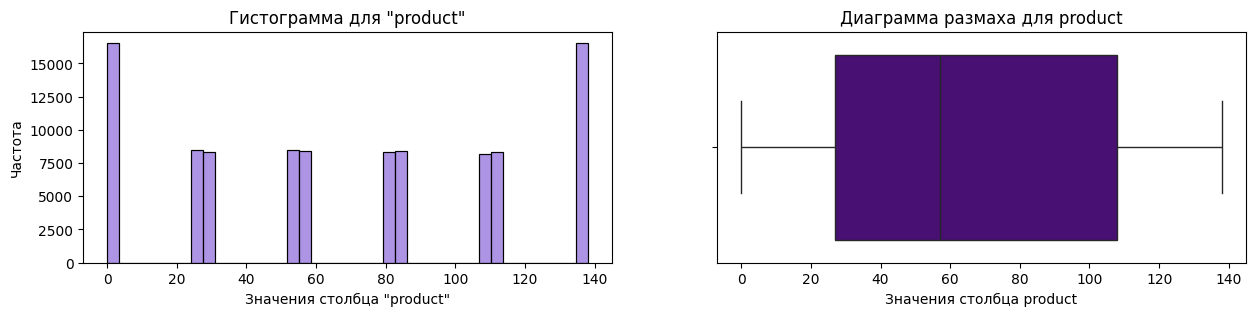

In [14]:
for name in num_col:
    hist_box(data_1, name)

- только признак `f1` распределен нормально.
- аномальных значений не наблюдается.

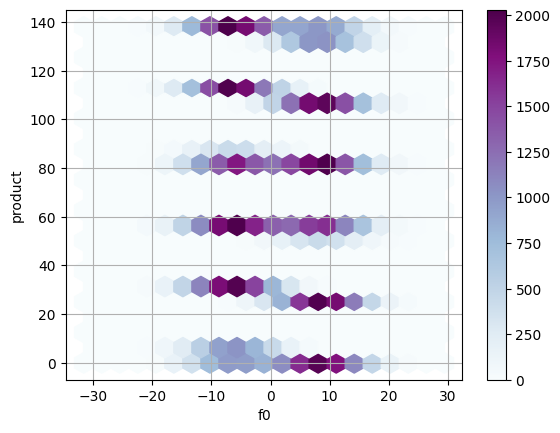

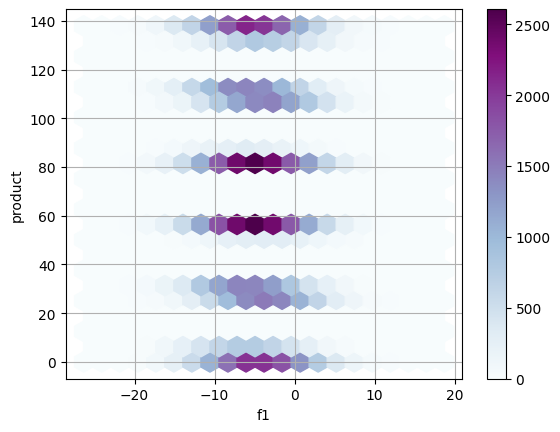

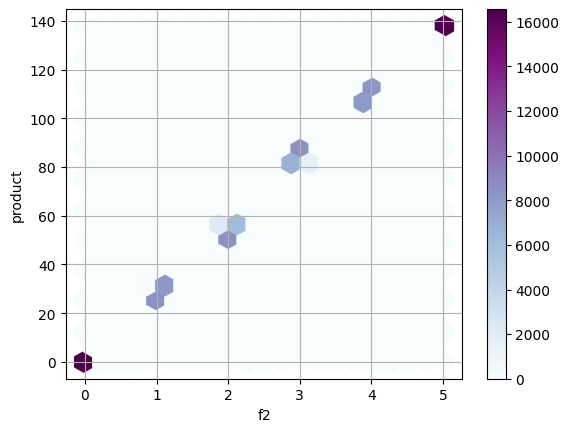

In [15]:
for name in num_col_1:
    data_1.plot(x=name, 
                y='product', 
                kind='hexbin', 
                gridsize=20, 
                sharex=False, 
                grid=True, 
                colormap='BuPu')

Также можно отметить, что явная линейная взаимосвязь наблюдается между целевой переменной и признаком `f2`.

### data_2

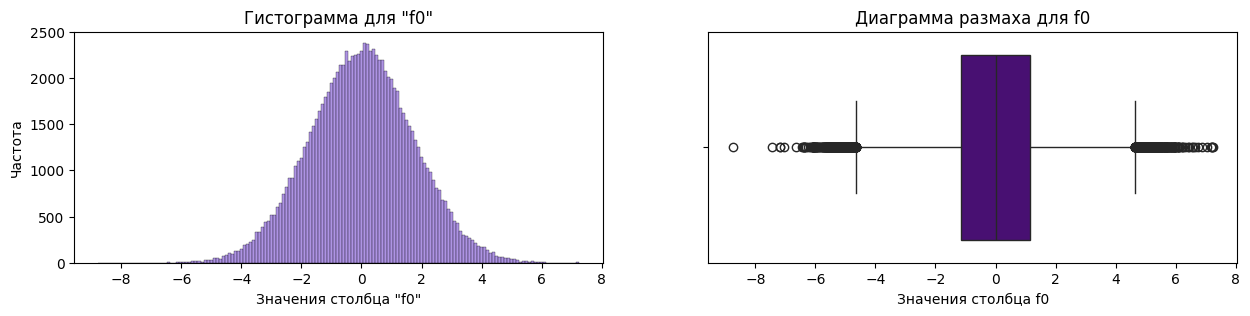

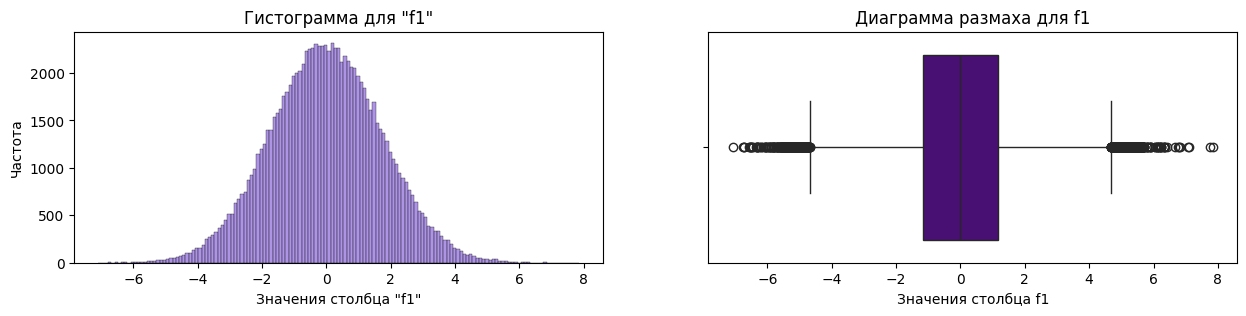

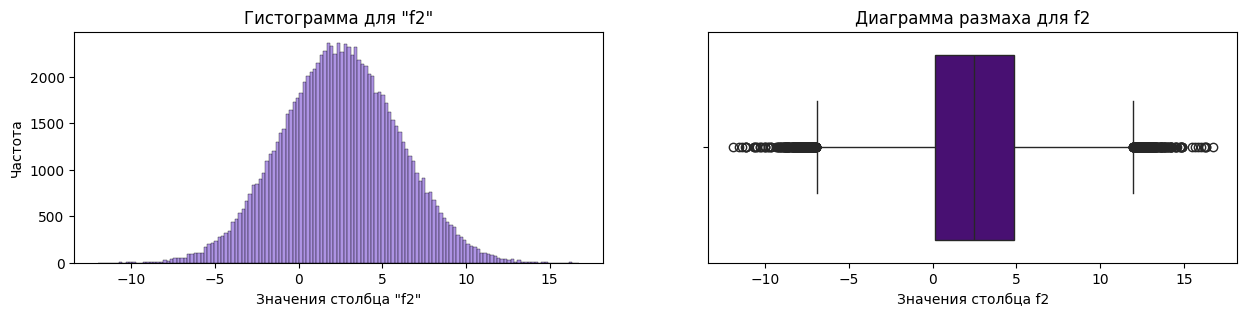

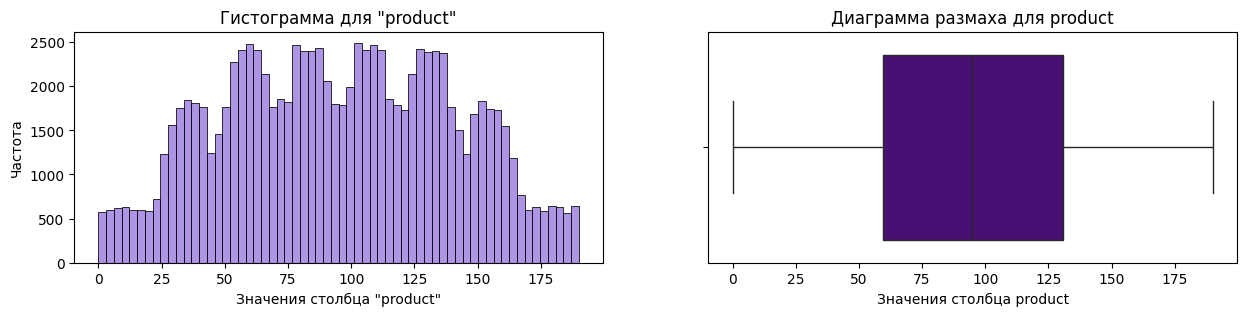

In [16]:
for name in num_col:
    hist_box(data_2, name)

- все признаки, в том числе и целевой, распределены нормально;
- аномальных значений не наблюдается.

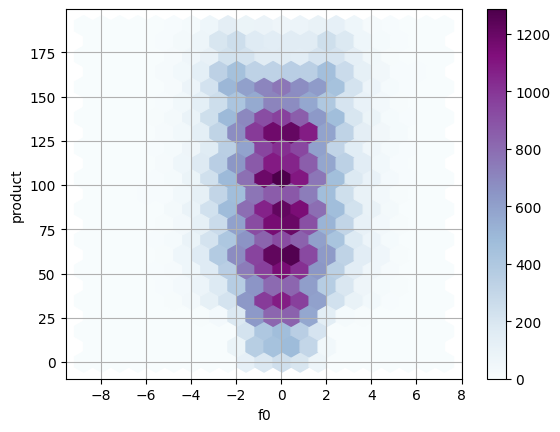

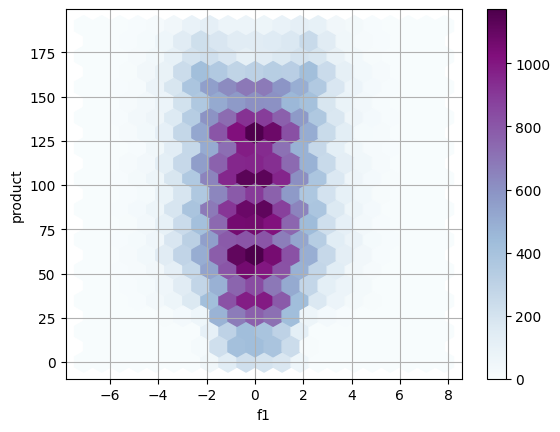

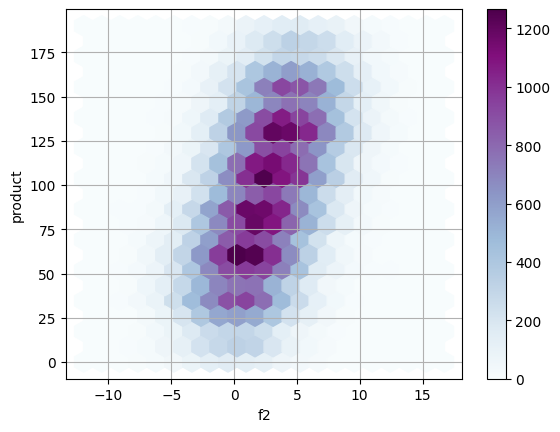

In [17]:
for name in num_col_1:
    data_2.plot(x=name, 
                y='product', 
                kind='hexbin', 
                gridsize=20, 
                sharex=False, 
                grid=True, 
                colormap='BuPu')

Также можно отметить, что явная линейная взаимосвязь наблюдается между целевой переменной и признаком `f2`.

## Корреляционный анализ

Поскольку некоторые их количественных признаков распределены ненормально, то анализ корреляции будем проводить с помощью библиотеки _phik_.

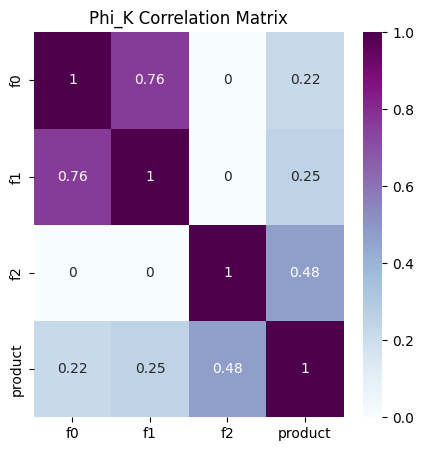

In [18]:
#вычисление матрицы корреляции
corr_matrix_0 = data_0.drop(['id'], axis=1).phik_matrix(interval_cols=num_col)

#визуализация матрицы корреляции 
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix_0, annot=True, cmap='BuPu')
plt.title('Phi_K Correlation Matrix')
plt.show()

Имеется высокая корреляция между:
* признаками `f0` и `f1`.

Мультиколлениарности признаков не наблюдается.

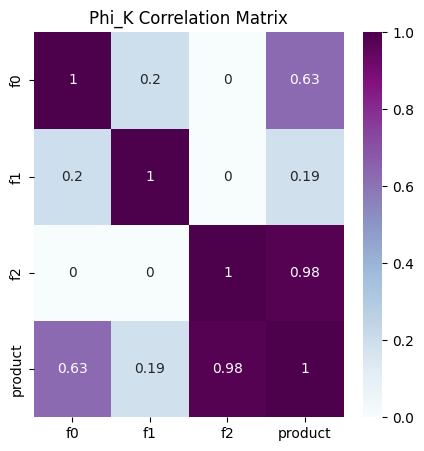

In [19]:
#вычисление матрицы корреляции
corr_matrix_1 = data_1.drop(['id'], axis=1).phik_matrix(interval_cols=num_col)

#визуализация матрицы корреляции 
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix_1, annot=True, cmap='BuPu')
plt.title('Phi_K Correlation Matrix')
plt.show()

Имеется высокая корреляция между:
* `f0` и `product`;
* `f2` и `product`. 

Поскольку нам доподлинно неизвестно что представляют собой входные признаки, то будем считать, что высокая корреляция признака f2 и целевой переменной не связана с возможной "утечкой" данных и оставим этот признак для обучения.

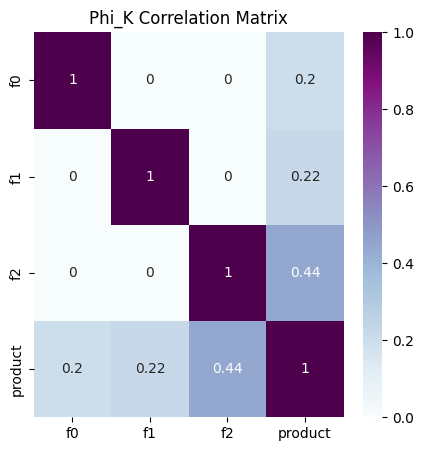

In [20]:
#вычисление матрицы корреляции
corr_matrix_2 = data_2.drop(['id'], axis=1).phik_matrix(interval_cols=num_col)

#визуализация матрицы корреляции 
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix_2, annot=True, cmap='BuPu')
plt.title('Phi_K Correlation Matrix')
plt.show()

- входные признаки практически не коррелируют между собой - мультиколлениарности не наблюдается.

## Обучение и проверка модели

### Подготовка данных

Признак 'id' не несет смысловой информации для модели, поэтому для обучения модели данный признак надо удалить из датасетов. После удаления необходимо проверить датасеты на наличие дубликатов, которые могут привести к переобучению модели.

In [21]:
df_0 = data_0.drop('id', axis=1)
df_0.duplicated().sum()

0

In [22]:
df_1 = data_1.drop('id', axis=1)
df_1.duplicated().sum()

0

In [23]:
df_2 = data_2.drop('id', axis=1)
df_2.duplicated().sum()

0

Явных дубликатов не обнаружено.

In [24]:
#создание функции для расчета метрик для регресионной модели

def metrics(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    MAE = mean_absolute_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print(f"R2 = {R2:.3f}")
    print(f"MSE = {MSE:.2f}")
    print(f"RMSE = {RMSE:.2f}")
    print(f"MAE = {MAE:.2f}")  

In [25]:
#создание фукнции для построения гистограммы распределения и дисперсии остатков

def residuals(y_true, y_pred):
    residuals = y_true - y_pred
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[1].scatter(x=y_pred, y=residuals, alpha=0.5)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

In [26]:
num_col = ['f0', 'f1', 'f2']

In [27]:
#создание фукнции для обучения модели линейной регрессии на количественных признаках
def modeling_linear(dataset, target, columns):
    
    #Разделение входных и целового признаков 
    X = dataset.drop(target, axis=1)
    y = dataset[target]
    
    #создание тренировочной и тестовой выборок
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        random_state=RANDOM_STATE)
    
    #масштабирование количественных признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[columns])
    X_test_scaled = scaler.transform(X_test[columns]) 
    
    #создание модели линейной регрессии
    model  = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    #расчет метрик
    res = residuals(y_test, prediction)
    metric_score = metrics(y_test, prediction)
    
    return X_test, y_test, prediction

### Обучение моделей

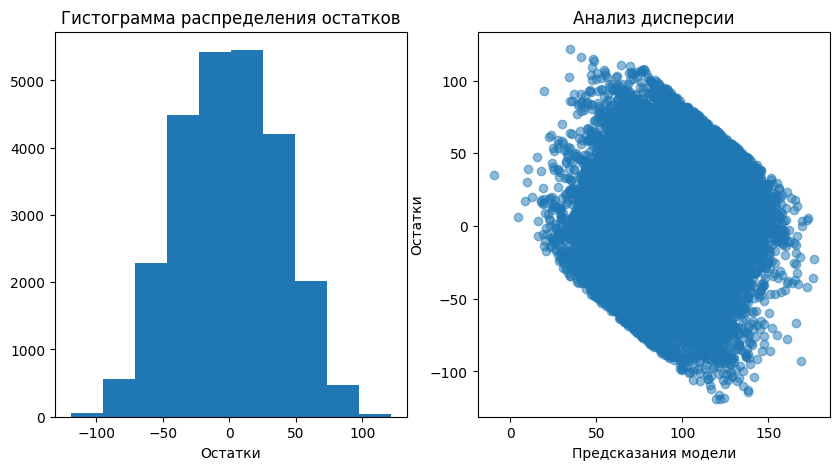

R2 = 0.273
MSE = 1425.56
RMSE = 37.76
MAE = 31.05
Средний запас предсказанного сырья: 92.4 тыс. баррелей


In [28]:
X_test_0, y_test_0, pred_0 = modeling_linear(df_0, 'product', num_col)
X_test_0['product_true'] = pd.Series(y_test_0)
X_test_0['product_pred'] = pred_0
print('Средний запас предсказанного сырья:', round(X_test_0['product_pred'].mean(), 2), 'тыс. баррелей')

Распределение остатков нормальное, однако наблюдается гетероскедастичность остатков. То есть модель на низких значениях их занижает, а на больших - завышает. 

Ключевая метрика RMSE равняется 37,76.

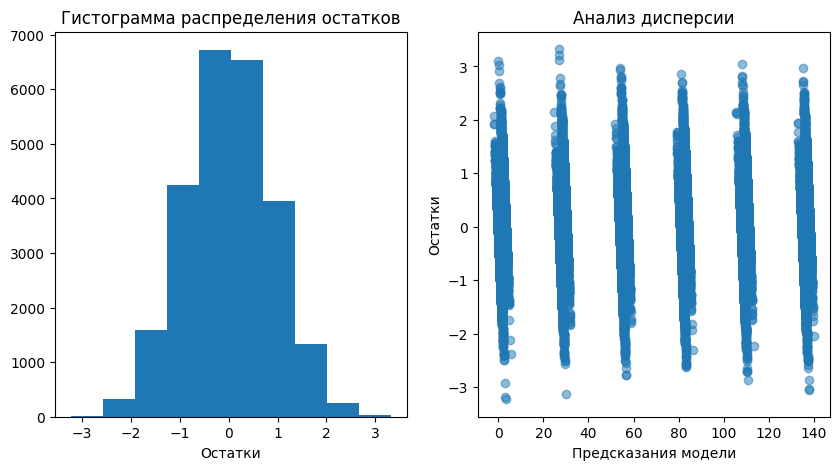

R2 = 1.000
MSE = 0.79
RMSE = 0.89
MAE = 0.72
Средний запас предсказанного сырья: 68.71 тыс. баррелей


In [29]:
X_test_1, y_test_1, pred_1 = modeling_linear(df_1, 'product', num_col)
X_test_1['product_true'] = pd.Series(y_test_1)
X_test_1['product_pred'] = pred_1
print('Средний запас предсказанного сырья:', round(X_test_1['product_pred'].mean(), 2), 'тыс. баррелей')

Нормальное распределение и гомоскедастичность остатков на лицо :)

Метрика RMSE составила 0,89. Это хорошая модель.

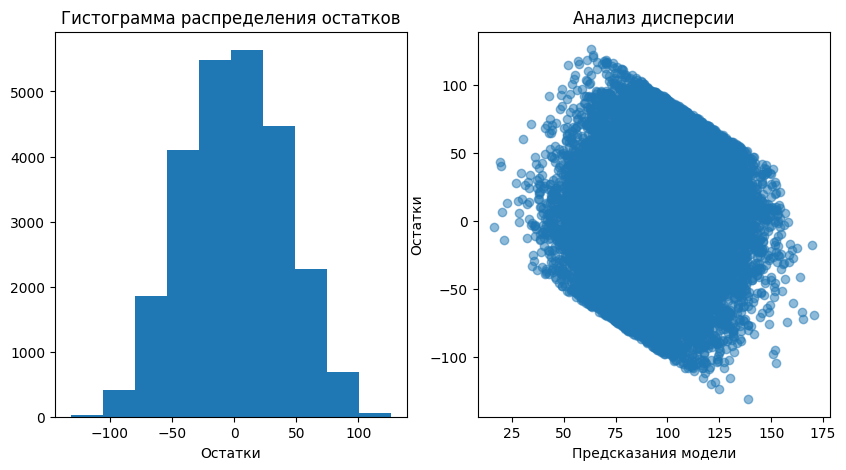

R2 = 0.196
MSE = 1611.69
RMSE = 40.15
MAE = 32.90
Средний запас предсказанного сырья: 94.77 тыс. баррелей


In [30]:
X_test_2, y_test_2, pred_2 = modeling_linear(df_2, 'product', num_col)
X_test_2['product_true'] = pd.Series(y_test_2)
X_test_2['product_pred'] = pred_2

print('Средний запас предсказанного сырья:', round(X_test_2['product_pred'].mean(), 2), 'тыс. баррелей')

Данная модель очень похожа на первую модель - равномерное распределение и гетероскедастичность остатков.

Метрика RMSE составила 40,15.

## Подготовка к расчёту прибыли

In [31]:
budget = 10000000000 #бюджет на разработку скважин
profit = 450000 #доход с 1 тысячи баррелей сырья

In [32]:
#расчет безубыточного количества добытого сырья
amount_well = budget / (profit * 200)
print(round(amount_well, 2), 'тыс. баррелей')

111.11 тыс. баррелей


Стоит отметить, что средние запасы предсказанного сырья во всех трех регионах меньше, чем необходимое безубыточное количество для одной скважины.

## Расчёт прибыли и рисков 

### Расчет прибыли с каждого региона

Для начала нам нужно выбрать 200 скважин с наибольшими предсказанными запасами сырья. Посчитать объём реально добытого сырья и посчитать прибыль с региона.


In [33]:
#фукнция для расчет прибыли с 200 лучших скважин
def revenue(dataset):
    df_sort = dataset.sort_values(by= 'product_pred', ascending=False).head(200)
    amount = df_sort['product_true'].sum()
    return profit * amount - budget

In [34]:
datasets = [X_test_0, X_test_1, X_test_2]

for idx, df in enumerate(datasets):
    print(f'Полученная прибыль с региона {idx + 1 }: {round(revenue(df)/1000, 1)} тыс. рублей')

Полученная прибыль с региона 1: 3359141.1 тыс. рублей
Полученная прибыль с региона 2: 2415086.7 тыс. рублей
Полученная прибыль с региона 3: 2598571.8 тыс. рублей


Наибольшая прибыль получена с **первого** региона. Наименьшная же со второго.

### Расчет рисков

In [35]:
#фукнция для проведения техники Бутстреп

def bootstrap_dataset(dataset):
    values = []
    for i in range(1000):
        subsample = dataset.sample(n=500, replace=True, random_state=state)
        values.append(revenue(subsample))
    
    values = pd.Series(values)
    
    #расчет 95% доверительного интервала
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975)
    
    #расчет среднего значения прибыли
    mean_revenue = values.mean()
    
    #расчет стандартного отклонения в выборке
    sigma = np.std(values)
    
    distr = st.norm(mean_revenue, sigma)
    x = 0 
    result = distr.cdf(x)
    
    return mean_revenue, lower, upper, result

In [36]:
#фукнция для проведения техники Бутстреп

def bootstrap_dataset_1(dataset):
    values = []
    for i in range(1000):
        subsample = dataset.sample(n=500, replace=True, random_state=state)
        values.append(revenue(subsample))
    
    values = pd.Series(values)
    
    #расчет 95% доверительного интервала
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975)
    
    #расчет среднего значения прибыли
    mean_revenue = values.mean()
    
    plt.figure(figsize=(5,5))
    plt.title('Гистограмма распределения прибыли')
    plt.hist(x=values, 
         color='MediumPurple');
    plt.xlabel('Прибыль, руб')
    plt.ylabel('Частота')
    plt.axvline(x=mean_revenue, color='r', label='Средняя прибыль')
    plt.axvline(x=lower, color='b')
    plt.axvline(x=upper, color='b')
    plt.legend(loc=0);
    
    result = (values[values < 0].count() / 1000)


    return mean_revenue, lower, upper, result

In [37]:
mean_revenue, lower, upper, result = bootstrap_dataset(X_test_0)
print('1-ый регион')
print(f'Средняя прибыль в регионе: {round(mean_revenue/1000, 0)} тыс. рублей') 
print(f'95% доверительный интервал: {lower, upper}')
print(f'Вероятность отрицательной прибыли: {round(result*100, 2)} %')

1-ый регион
Средняя прибыль в регионе: 406279.0 тыс. рублей
95% доверительный интервал: (-117742136.49486831, 911737050.7514055)
Вероятность отрицательной прибыли: 6.09 %


1-ый регион
Средняя прибыль в регионе: 382379.0 тыс. рублей
95% доверительный интервал: (-127810424.72292751, 874616684.1419048)
Вероятность отрицательной прибыли: 6.1 %


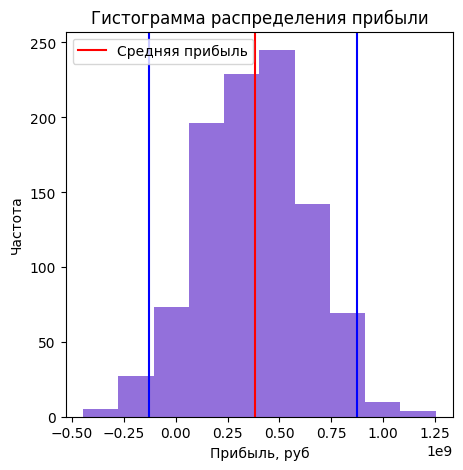

In [38]:
mean_revenue, lower, upper, result= bootstrap_dataset_1(X_test_0)
print('1-ый регион')

print(f'Средняя прибыль в регионе: {round(mean_revenue/1000, 0)} тыс. рублей') 
print(f'95% доверительный интервал: {lower, upper}')
print(f'Вероятность отрицательной прибыли: {round(result*100, 2)} %')

In [39]:
mean_revenue, lower, upper, result = bootstrap_dataset(X_test_1)
print('2-ой регион')
print(f'Средняя прибыль в регионе: {round(mean_revenue/1000, 0)} тыс. рублей') 
print(f'95% доверительный интервал: {lower, upper}')
print(f'Вероятность отрицательной прибыли: {round(result*100, 2)} %')

2-ой регион
Средняя прибыль в регионе: 438776.0 тыс. рублей
95% доверительный интервал: (35985063.59259497, 833114800.3018101)
Вероятность отрицательной прибыли: 1.44 %


2-ой регион
Средняя прибыль в регионе: 443196.0 тыс. рублей
95% доверительный интервал: (21770846.72205544, 820175680.0108408)
Вероятность отрицательной прибыли: 1.9 %


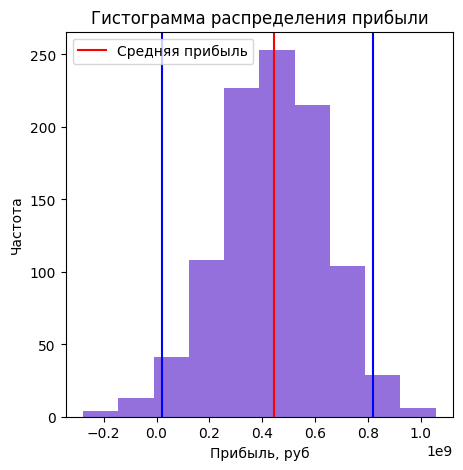

In [40]:
mean_revenue, lower, upper, result= bootstrap_dataset_1(X_test_1)
print('2-ой регион')

print(f'Средняя прибыль в регионе: {round(mean_revenue/1000, 0)} тыс. рублей') 
print(f'95% доверительный интервал: {lower, upper}')
print(f'Вероятность отрицательной прибыли: {round(result*100, 2)} %')

In [41]:
mean_revenue, lower, upper, result = bootstrap_dataset(X_test_2)
print('3-ий регион')
print(f'Средняя прибыль в регионе: {round(mean_revenue/1000, 0)} тыс. рублей') 
print(f'95% доверительный интервал: {lower, upper}')
print(f'Вероятность отрицательной прибыли: {round(result*100, 2)} %')

3-ий регион
Средняя прибыль в регионе: 387379.0 тыс. рублей
95% доверительный интервал: (-134459245.40228906, 889792133.1743371)
Вероятность отрицательной прибыли: 7.23 %


3-ий регион
Средняя прибыль в регионе: 380561.0 тыс. рублей
95% доверительный интервал: (-139226959.2015896, 898147119.6809006)
Вероятность отрицательной прибыли: 6.8 %


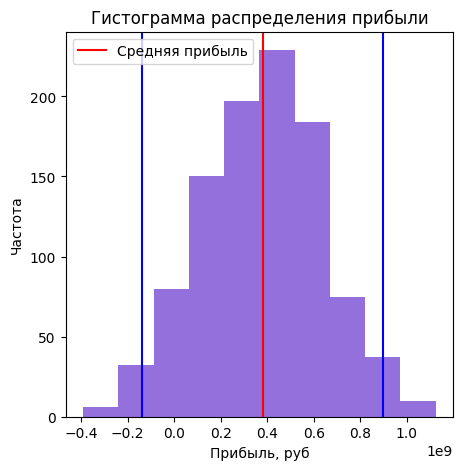

In [42]:
mean_revenue, lower, upper, result= bootstrap_dataset_1(X_test_2)
print('3-ий регион')

print(f'Средняя прибыль в регионе: {round(mean_revenue/1000, 0)} тыс. рублей') 
print(f'95% доверительный интервал: {lower, upper}')
print(f'Вероятность отрицательной прибыли: {round(result*100, 2)} %')

Наиболее прибыльным оказывается 2-ой регион. Также он удовлетворяет условиям по вероятности убытков менее 2,5% - в данном регионе она составила 1,8%.

## Вывод

В данном проекте были проанализированны данные о трех регионов месторождений нефти с целью определения наиболее прибыльные и менее рискованного для разработки региона.
Данные были предоставлены в трех файлах - geo_data_0.csv, geo_data_1.csv, geo_data_2.csv, которые содержали в себе следующие сведения:
1. id — уникальный идентификатор скважины;
2. f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
2. product — объём запасов в скважине (тыс. баррелей)

По каждому региона была обучения модель линейной регрессии для предсказания объёма добываемого сырья на основе входных признаков. Лучшей моделью оказалась модель для **второго** региона, у которой ключевая метрика RMSE составила 0,89. В то же время у других моделей эта метрика равнялась 37,79 и 40,15, соответственно. 

Далее для каждого региона была рассчитана прибыль. Для этого на основании предсказаных объёмов добываемого сырья были выбраны 200 скважин, реальное количество добытого сырья было умножено на цену 1 тысячи баррелей сырья и вычтен бюджет, выданных на разработку скважин. Наиболее прибыльным оказался **1-ый** регион.

Далее были рассчитаны риски убытков. Наименее убыточным можно считать 2-ой регион, в нем вероятность убытков составила 1,9%. 

Так что для дальнейшей разработки месторождений стоит остановится на **втором** регионе, поскольку он наименее убыточен и по уже имеющимся данным прибыль в нем была не отрицательной и составила **2415086.7 тыс. рублей.**